In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os
import sys

# Add project root to path - adjust the number of parent dirs (..) based on where your notebook is located
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import src.visualization as vis


from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Visualization

For visualization we have one main class:
    - `vis.GameVisualizer`: for visualizing a game or multiple games from the dataset.

And two helper classes:
    - `analysis.GridAnalyzer`: for analyzing the grid of a game.
    - `vis.BaseVisualizer`: for plotting the grid of a game.

`GameVisualizer` is the main class for visualizing games. It provides higher level methods for visualizing the game grid, trajectories, and recurrence grids.

`GridAnalyzer` is a helper class that provides methods for analyzing the grid of a game. It is used to calculate the recurrence grid, velocity grid, and count grid of a game.

`BaseVisualizer` is a helper class that provides methods for plotting the grid of a game. It is used to plot the walls, pellets, and recurrence grid of a game is used by `GameVisualizer` and `GridAnalyzer`, not by user.

GridAnalyzer can be used for granular analysis of games and sub-trajectories.


In [2]:
GAME = 602
visualizer = vis.GameVisualizer(data_folder="../data/", verbose=True, figsize=[8, 8])

### Scatter
Scatter plot will provide the most basic and "raw" visualization of the movement data. This is the only visualization that does not involve the use of a gridmap for its construction.

Pros:
- Helpful to visualize the raw data.

Cons:
- Pretty useless for everything else.

INFO - src.datahandlers.pacman_data_reader - Found 1 levels for level [602]


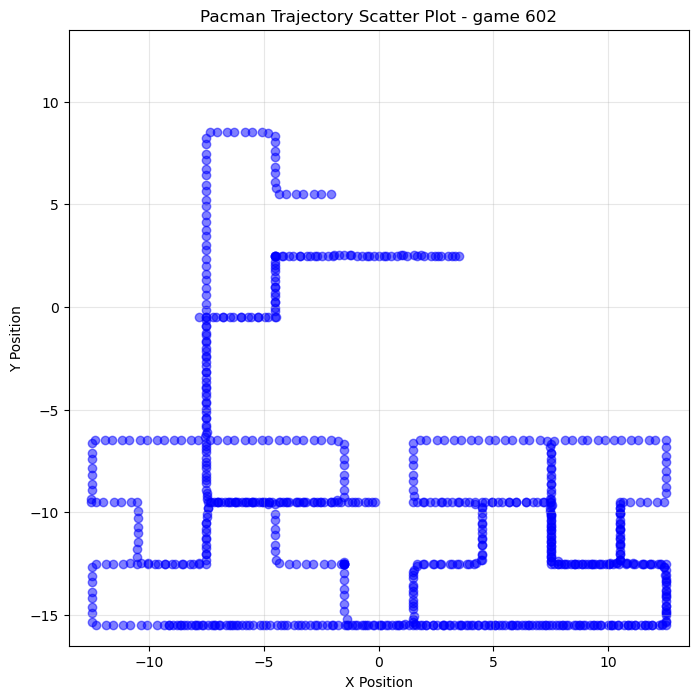

In [3]:
visualizer.plot_trajectory_scatter(level_id=GAME)

The following plots all calculate grids for visualization. (See below GridAnalyzer)

### Line Interpolation
Line interpolation uses the recurrence grid (see below) to assign an offset on recurrent paths. It uses colour to encode time

Pros:
- encodes time and directionality
- clearer representation of the trajectory (no averages, no overlapping)

Cons:
- Gets very messy on very recurrent areas
- At least in its current form, it cannot be easily used for aggregated analysis (e.g., to visualize patterns of a cluster of games). See Chittaro et al. (2006) for possible improvements

INFO - src.datahandlers.pacman_data_reader - Found 1 levels for level [602]


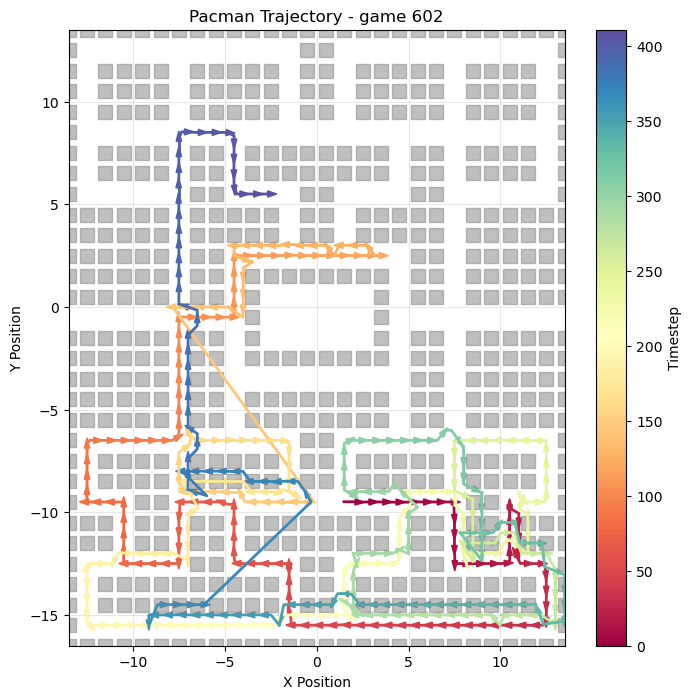

In [4]:
visualizer.plot_trajectory_line(level_id=GAME, time_step_delta=2, arrow_spacing=1)

### Heatmap
It plots the recurrence grid as a heatmap.

Pros:
- Visualize recurrent areas.
- Useful for aggregate analysis

Cons:
- No directionaliy encoding
- No temporal encoding

INFO - src.datahandlers.pacman_data_reader - Found 1 levels for level [602]


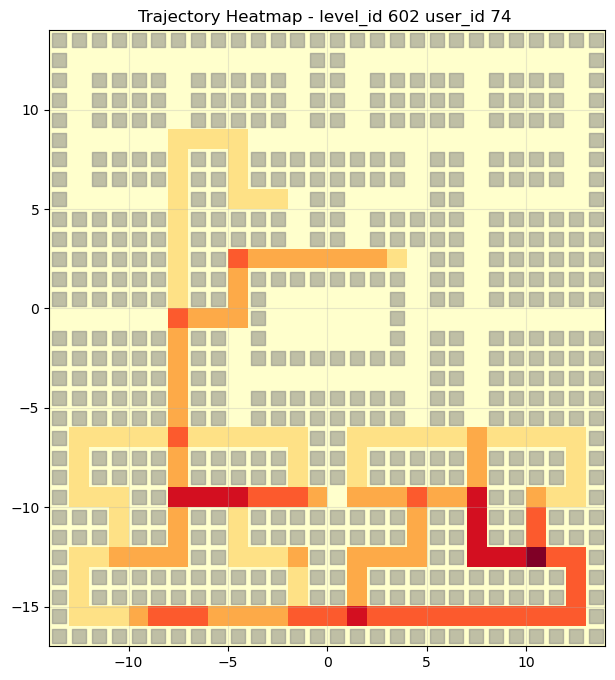

In [5]:
visualizer.plot_heatmap(
    level_id=GAME, normalize=False, metadata_label=["level_id", "user_id"]
)

# visualizer.plot_heatmap(game_id= range(600,700), normalize=True)

#### Velocity
This method plots the average velocity per grid. 

pros:
- Can identify directional patterns per area
- Useful for aggregate analysis

cons:
- No temporal encoding
- As it calculates averages per grid, it needs to be improved upon to help differentiate between grids where the instantaneous vectors cancel out and the untraversed grids.

INFO - src.datahandlers.pacman_data_reader - Found 1 levels for level [602]


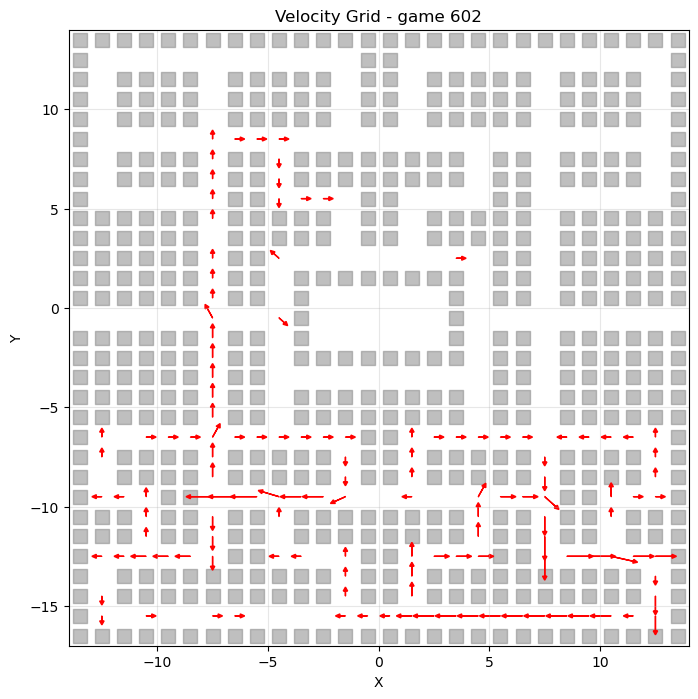

In [6]:
# visualizer.plot_velocity_grid(game_id=GAME, normalize=True) ## For individual games, normalize will just produce unitary vectors.
visualizer.plot_velocity_grid(level_id=GAME, normalize=False)

### Multi-plot visualization

All plot methods can be used for subplots visualizations. Additionally, `self.plot_multiple_trajectories()` creates subplots of multiple trajectories.

INFO - src.datahandlers.pacman_data_reader - Found 1 levels for level [600]
INFO - src.datahandlers.pacman_data_reader - Found 1 levels for level [601]
INFO - src.datahandlers.pacman_data_reader - Found 1 levels for level [602]
INFO - src.datahandlers.pacman_data_reader - Found 1 levels for level [603]


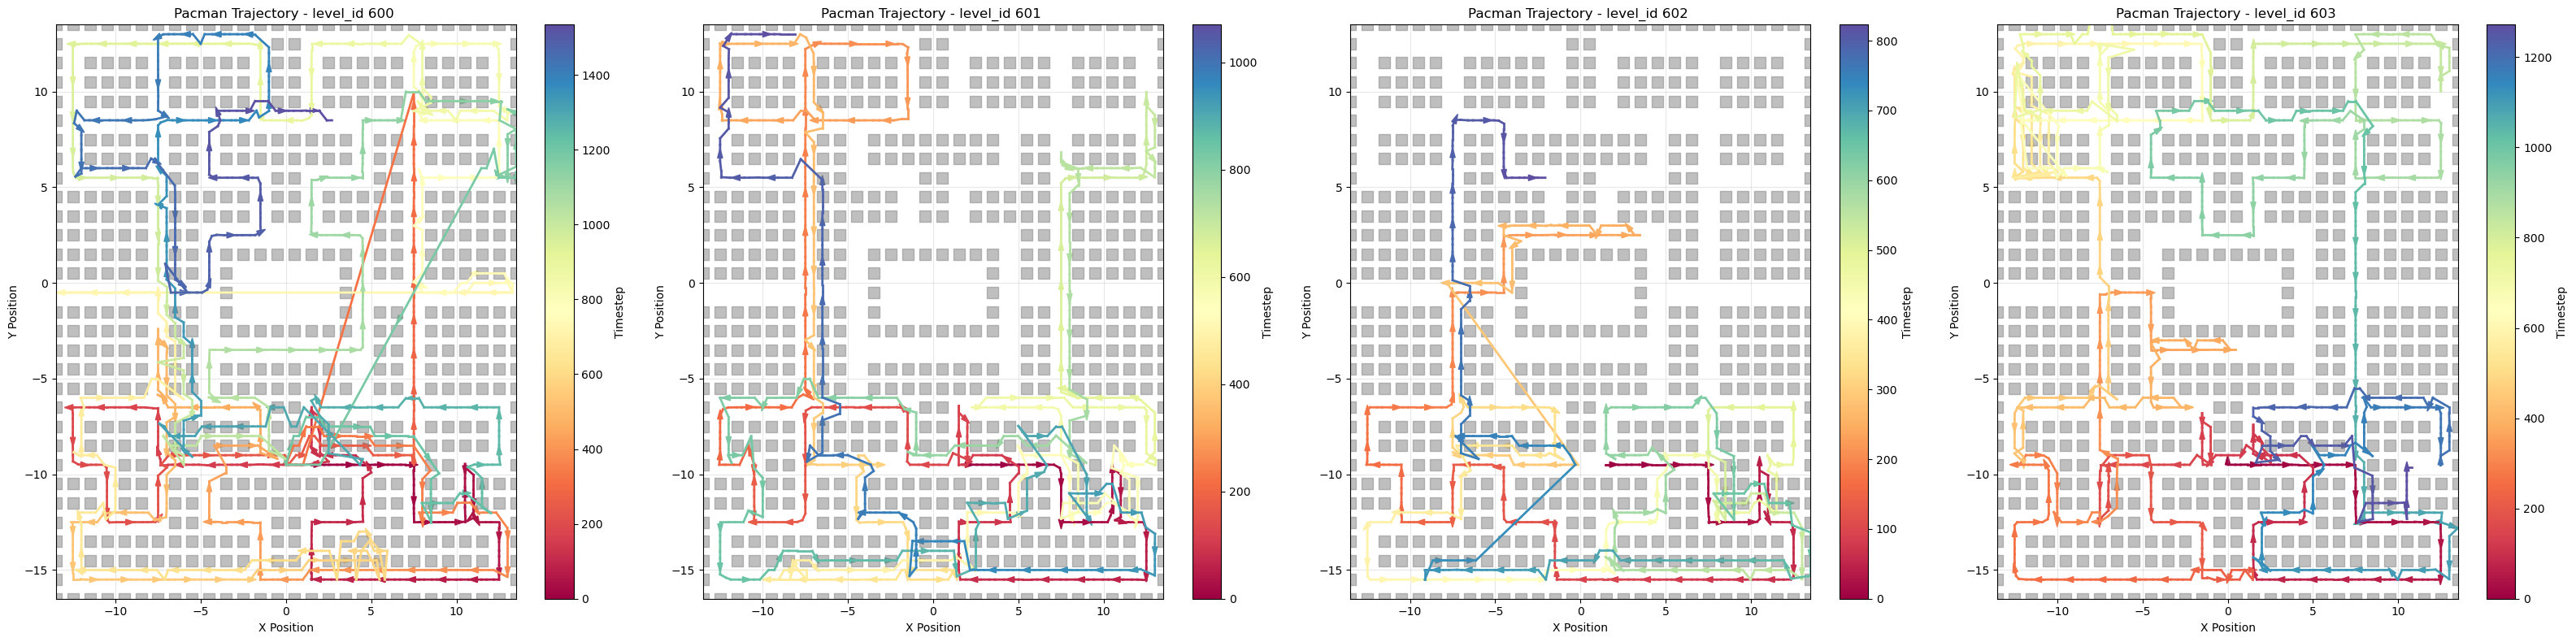

In [7]:
### Using the dedicated method (useful for comparisons).
visualizer.plot_multiple_trajectories(level_ids=range(600, 604), plot_type="line")

INFO - src.datahandlers.pacman_data_reader - Found 1 levels for level [602]
INFO - src.datahandlers.pacman_data_reader - Found 1 levels for level [602]
INFO - src.datahandlers.pacman_data_reader - Found 1 levels for level [602]


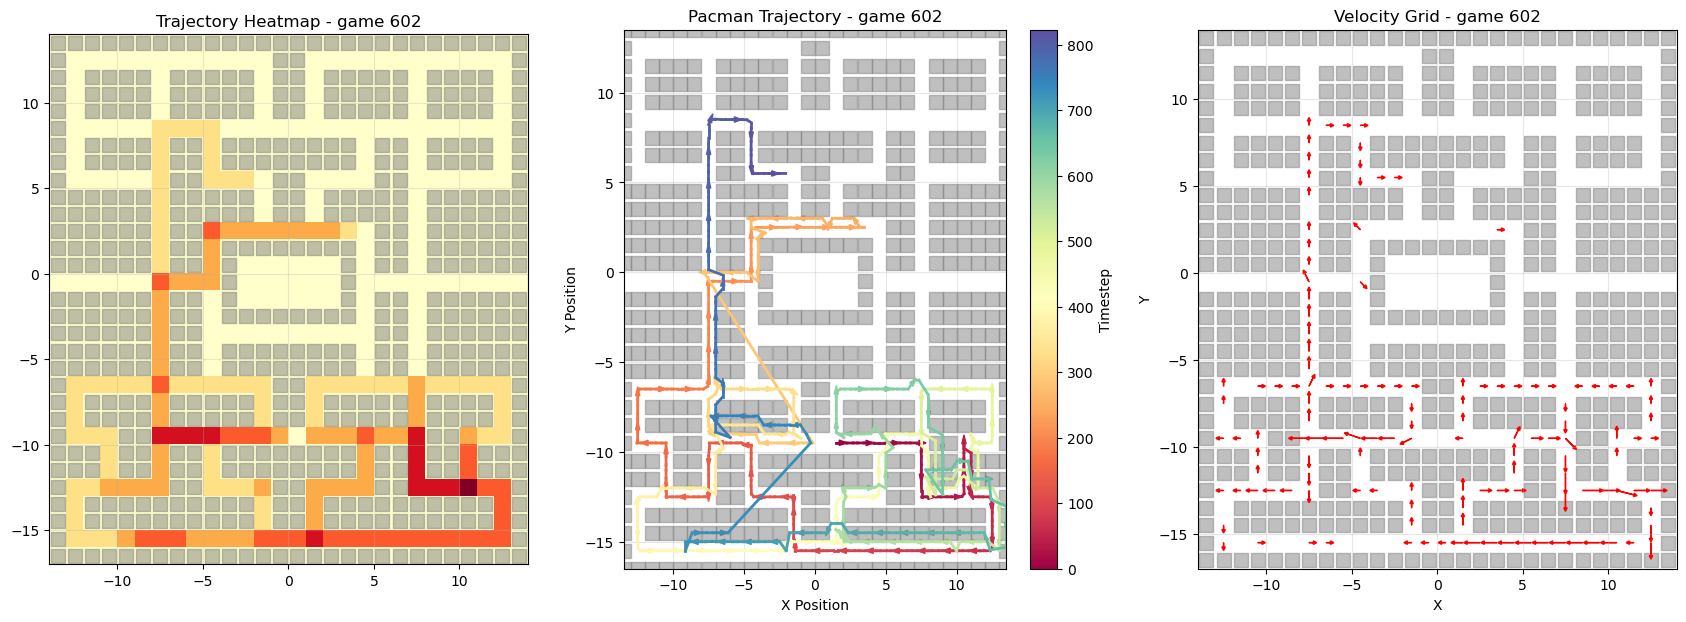

In [8]:
### Creating subplots and passing the axes to plotting methods.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 7))

visualizer.plot_heatmap(level_id=GAME, ax=ax1)
visualizer.plot_trajectory_line(level_id=GAME, ax=ax2)
visualizer.plot_velocity_grid(level_id=GAME, ax=ax3)

Passing Trajectories

WARNING - src.datahandlers.trajectory - Trajectory for game 676 ends before the inputed end step (177 < 300). Returning segment until last observed position instead.


True

True

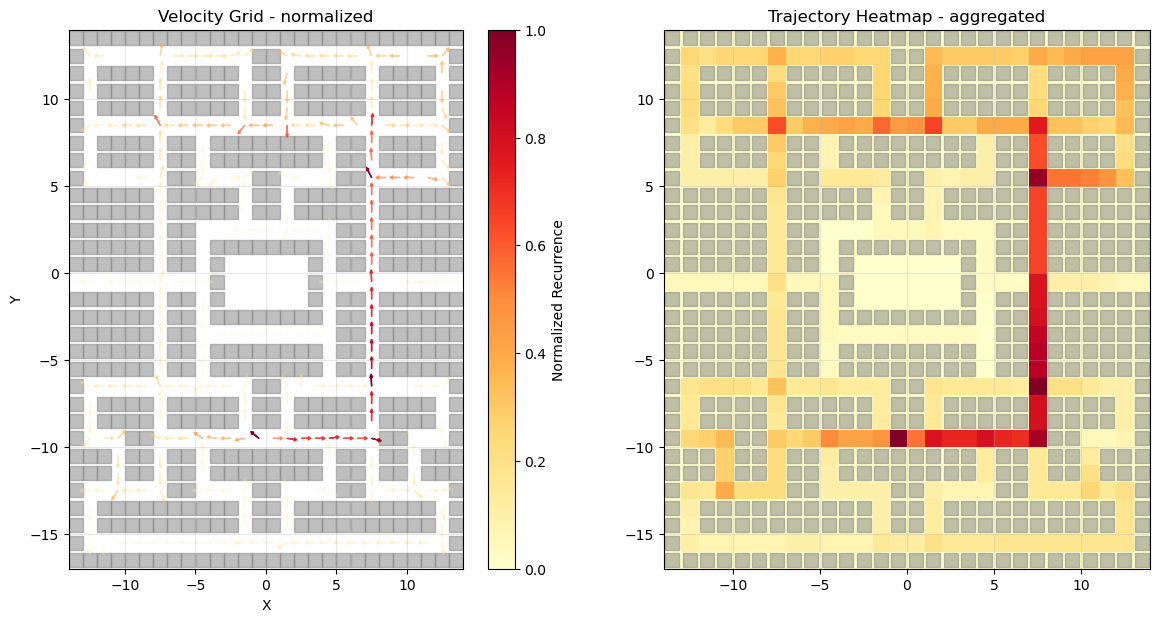

In [10]:
from src.datahandlers import PacmanDataReader, Trajectory

data = PacmanDataReader(data_folder="../data/")

cluster = [
    399,
    401,
    402,
    413,
    471,
    475,
    477,
    480,
    485,
    573,
    582,
    584,
    588,
    596,
    618,
    676,
    681,
    685,
    722,
    723,
    728,
    760,
    776,
    832,
    843,
]  # A group of ids with a common starting pattern (Firsty 50 steps)

## To get all trajectories as a list[Trajectory]
all_trajs = []
for level_id in cluster:
    traj = data.get_trajectory(level_id=level_id, include_metadata=True).get_segment(end_step=300)
    all_trajs.append(traj)

isinstance(all_trajs, list)
isinstance(all_trajs[0], Trajectory)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
visualizer.plot_velocity_grid(
    trajectory=all_trajs,
    metadata_label="level_id",
    normalize=True,
    ax=ax1,
    title_id="normalized",
)
visualizer.plot_heatmap(
    trajectory=all_trajs, metadata_label="level_id", normalize=False, ax=ax2
)  # Normalization is forced for list (change if required to debug)

### Grid Analyzer

Underlying these plots there is the `GridAnalyzer` class, which calculates the recurrence and average speeds on each grid cell. This works both in a single trajectory as well as for aggregate data. Important element in the analyzer is how recurrent steps are considered. To avoid grid agglomeration, datapoints that are within 4 steps distance are not added together in a same gridcell (as another step in the same grid, or to the velocity aggregation). This step distance seems stable but it might be tuned later.

```python       
...
# Assign vectors to grid cells
        for i in range(len(x)):
            x_idx = np.argmin(np.abs(self.x_grid - x[i]))
            y_idx = np.argmin(np.abs(self.y_grid - y[i]))
            # Accumulate vectors only if the positions are non-consecutive in the idx_grid
            if i > 0:
                if (not self.recurrence_idx_grid[y_idx, x_idx]) or (
                    i - self.recurrence_idx_grid[y_idx, x_idx][-1] > 4 ### Step distance
                ):
                    self.recurrence_count_grid[y_idx, x_idx] += 1
                    self.recurrence_idx_grid[y_idx, x_idx].append(i)
                    if calculate_velocities:
                        # because vel. are calculated with prepended x and y values, we need to subtract 1 from the index to get the correct velocity
                        self.velocity_grid[y_idx, x_idx] += np.array(
                            [dx[i - 1], dy[i - 1]]
                        )
                        ...
```